In [1]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.linear_model import LinearRegression

from IPython.display import clear_output

In [2]:
PREDICTIONS_DIR = "predictions"

IS_SHORT_TERM = True
SEED = 9

In [3]:
model_data = pd.read_csv(f"{PREDICTIONS_DIR}/model_data.csv")

In [4]:
model_data = model_data[model_data["seed"] == SEED]
model_data = model_data[model_data["is_short_term"] == IS_SHORT_TERM]
model_data

,name,seed,is_short_term,validation_spearman_rank,type,feature,predictions,notes,parameters
8,glove_gru,9,True,0.2382,gru,glove,predictions/glove_gru/st-9.csv,NaN,"{'random_seed': 9, 'num_epochs': 150, 'hidden_..."
9,vggish_bayesian_ridge,9,True,0.2644,bayesian_ridge,vggish,predictions/vggish_bayesian_ridge/st-9.csv,NaN,{'random_seed': 9}
10,c3d_svr,9,True,0.2229,svr,c3d,predictions/c3d_svr/st-9.csv,NaN,{'random_seed': 9}
11,resnet152_svr,9,True,0.0686,svr,resnet152,predictions/resnet152_svr/st-9.csv,NaN,{'random_seed': 9}


In [5]:
def get_prediction_df(df):
    preds = []
    names = []
    actual = None
    video_ids = None
    is_training = None
    
    for i, row in df.iterrows():
        prediction_data = pd.read_csv(row["predictions"])
        if actual is None:
            actual = np.array(prediction_data["actual"])
            actual_no_nan = actual[~np.isnan(actual)]
            is_training = np.array(prediction_data["in_training_set"])
            video_ids = prediction_data["video_id"]
        
        file_actual = np.array(prediction_data["actual"])
        assert np.allclose(actual_no_nan, file_actual[~np.isnan(file_actual)])
        if not np.equal(is_training, np.array(prediction_data["in_training_set"])).all():
            for a,b,vid in zip(is_training, prediction_data["in_training_set"], video_ids):
                if a!=b:
                    print(a,b, vid)
        assert np.equal(video_ids, np.array(prediction_data["video_id"])).all()
        
        names.append(row["name"])
        preds.append(prediction_data["prediction"])
        
    pred_df = pd.DataFrame({
        "actual": actual,
        "video_id": video_ids,
        "is_training": is_training,
    })
    
    for pred, name in zip(preds, names):
        pred_df[name] = pred
    
    return pred_df.set_index("video_id")

In [6]:
pred_df = get_prediction_df(model_data)

In [7]:
def get_train_matrixes(df):
    train_df = df[df["is_training"] == True]
    targets = train_df["actual"]
    vids = train_df.index
    feature_df = train_df.drop(["actual", "is_training"], axis = 1)
    return np.array(feature_df), np.array(targets), vids, list(feature_df.columns)

In [8]:
def get_valid_matrixes(df):
    not_train_df = df[df["is_training"] == False]
    valid_df = not_train_df[np.logical_not(np.isnan(not_train_df["actual"]))]
    targets = valid_df["actual"]
    vids = valid_df.index
    feature_df = valid_df.drop(["actual", "is_training"], axis = 1)
    return np.array(feature_df), np.array(targets), vids, list(feature_df.columns)

In [9]:
def get_test_matrixes(df):
    not_train_df = df[df["is_training"] == False]
    test_df = not_train_df[np.isnan(not_train_df["actual"])]
    targets = test_df["actual"]
    vids = test_df.index
    feature_df = test_df.drop(["actual", "is_training"], axis = 1)
    return np.array(feature_df), np.array(targets), vids, list(feature_df.columns)

In [10]:
X_train, y_train, vids_train, features = get_train_matrixes(pred_df)
X_valid, y_valid, vids_valid, _features = get_valid_matrixes(pred_df)
assert _features == features
X_test, y_test, vids_test, _ = get_test_matrixes(pred_df)
assert _features == features

In [11]:
X_train.shape

(472, 4)

In [12]:
def generate_splits(n, num_splits):
    if num_splits == 1:
        yield [n]
    elif n == 0:
        yield [0 for _ in range(num_splits)]
    else:
        for i in range(n + 1):
            for subsplit in generate_splits(n-i, num_splits-1):
                yield [i] + subsplit

In [13]:
len(X_valid) // 2

59

In [14]:
def calculate_splits(n, features, feature_matrix, target_matrix, seed = 1):
    num_splits = len(features)
    best_split = []
    best_rank = 0
    
    df = pd.DataFrame(columns = ["spearman_rank", "p-value"] + list(features))
    
    for split in generate_splits(n, num_splits):
        fractions = np.array(split) / n
        spearman_rank, p = stats.spearmanr(
            target_matrix, 
            np.dot(feature_matrix, fractions))
        weights = {
            feature: weight for feature, weight in zip(features, fractions)
        }
        weights["spearman_rank"] = spearman_rank
        weights["p-value"] = p
        df = df.append(weights, ignore_index=True)
        
    return df.sort_values("spearman_rank", ascending=False).reset_index(drop=True)

split_df = calculate_splits(20, features, X_valid, y_valid)

In [15]:
split_df

,spearman_rank,p-value,glove_gru,vggish_bayesian_ridge,c3d_svr,resnet152_svr
0,0.369693,0.000038,0.45,0.50,0.05,0.00
1,0.368517,0.000040,0.40,0.50,0.10,0.00
2,0.365208,0.000048,0.40,0.45,0.15,0.00
3,0.364894,0.000049,0.50,0.45,0.05,0.00
4,0.364675,0.000049,0.35,0.50,0.15,0.00
...,...,...,...,...,...,...
1766,0.081861,0.378183,0.10,0.00,0.00,0.90
1767,0.077303,0.405391,0.05,0.00,0.00,0.95
1768,0.075250,0.418011,0.00,0.05,0.00,0.95
1769,0.074600,0.422055,0.00,0.00,0.05,0.95


In [16]:
best_split = split_df.iloc[0]

In [27]:
print(best_split)

spearman_rank            0.369693
p-value                  0.000038
glove_gru                0.450000
vggish_bayesian_ridge    0.500000
c3d_svr                  0.050000
resnet152_svr            0.000000
Name: 0, dtype: float64


In [18]:
best_split

spearman_rank            0.369693
p-value                  0.000038
glove_gru                0.450000
vggish_bayesian_ridge    0.500000
c3d_svr                  0.050000
resnet152_svr            0.000000
Name: 0, dtype: float64

In [19]:
split_df.to_csv(f"{'st' if IS_SHORT_TERM else 'lt'}_ensemble_{SEED}.csv")

In [20]:
def get_ensemble_predictions(feature_matrix, features, split):
    weights = [split[f] for f in features]
    return np.dot(feature_matrix, weights)

In [21]:
preds_valid = get_ensemble_predictions(X_valid, features, split_df.iloc[0])

In [22]:
stats.spearmanr(preds_valid, y_valid)

SpearmanrResult(correlation=0.3696931184468572, pvalue=3.7872456914339764e-05)

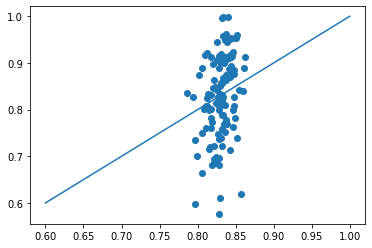

In [23]:
import matplotlib.pyplot as plt
plt.scatter(preds_valid, y_valid)
plt.plot([.6, 1], [.6,1])

In [24]:
preds_test = get_ensemble_predictions(X_test, features, split_df.iloc[0])

In [25]:
confidence = np.ones(len(preds_test))

In [26]:
assert False

AssertionError: 

In [ ]:
final = pd.DataFrame({
    "videoname": vids_test,
    "memorability_score": preds_test,
    "confidence": confidence
})

In [ ]:
final.to_csv("me19mem_ucb_shorterm_run3.csv",header=False, index=False)

In [ ]:
final